## Problema de Negócio

O conjunto de dados está disponível na plataforma do Kaggle, através desse link: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction 

Cada linha representa um cliente e cada coluna contém alguns atributos que descrevem esse cliente, além da sua resposta à pesquisa, na qual ela mencionou interesse ou não ao novo produto de seguros. 

O conjunto de dados inclui as seguintes informações:

Id: identificador único do cliente.

Gender: gênero do cliente.

Age: idade do cliente.

Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )

Region Code: código da região do cliente.

Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.

Vehicle Age: idade do veículo.

Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.

Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.

Policy sales channel: código anônimo para o canal de contato com o cliente.

Vintage: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.

Response: 0, o cliente não tem interesse e 1, o cliente tem interesse.

# 0.0 Imports 

In [1]:
import os
import inflection
import pickle
import pandas         as pd
import numpy          as np
import seaborn        as sns

import scikitplot        as skplt
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from matplotlib              import gridspec

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn                 import preprocessing   as pp
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn                 import linear_model    as lm
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split


## 0.01 Helper Function

In [2]:
#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    
#    plt.style.use( 'bmh' )
#    plt.rcParams['figure.figsize'] = [25, 12]
#    plt.rcParams['font.size'] = 24
#    
#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    
#    sns.set()
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
        
def cat_count_plotting( dataframe, column, ax, x_label_rotation = False ):
    '''Plot countplot for the given column of dataframe'''
    
    # plot countplot
    sns.countplot(x = column, data = dataframe, ax = ax)
    
    # set title to column name
    ax.set_title( column.replace('_', ' ').upper() )
    
    # rotate x label if necessary
    if x_label_rotation == True:
        plt.xticks(rotation=90);


    return None       


def numerical_plot( dataframe, column, hist_axs, box_axs,
                  hist_label_rot = 0, box_label_rot = 0):
    '''Plot histogram on the hist_axs and boxplot on the box_axs
    
    Args:
        dataframe: datataframe with numerical features
        column: numerical feature to be plotted
        hist_axs: ax for histogram plot
        box_axs: ax for box plot
        hist_label_rot: angle of rotation for histogram label
        box_label_rot angle of rotation for boxplot label
    
    Return:
        None
    '''
       
    # set title
    hist_axs.set_title( column.upper() )
    # plot histogram
    sns.histplot( x = column, data = dataframe, ax = hist_axs, kde = True )
    #plot boxplot
    sns.boxplot(  x = column, data = dataframe, ax = box_axs )
    
    # rotate histogram x label if requested
    if hist_label_rot > 0 :
        hist_axs.tick_params( axis = 'x', rotation = hist_label_rot )
    # rotate boxplot x label if requested
    if box_label_rot:
        box_axs.tick_params( axis = 'x', rotation = box_label_rot )
        
    
    return None

def propensity_score_ordering( x_validation, y_validation, yhat):
    '''Order the dataframe according to propensity score
    
    Args:
        x_validation: x_validation dataframe
        y_validation: y_validation dataframe
        y_hat: predictions made with predict_proba method for x_validation
    
    Return:  
        df_propensity_ordered: dataframe with x_validation columns, 
                               response column (y_validation_column) and 
                               score column (propensity of being interested).
                               Dataframe is ordered according to propensity score in
                               descending order'''
    
    # make a copy x_validation and y_validation
    df_propensity_ordered = x_validation.copy()
    df_propensity_ordered['response'] = y_validation.copy()

    # create a column with probability of being 1 (interested)
    df_propensity_ordered['score'] = yhat[:, 1].tolist()

    # sorte dataframe according to propensity score
    df_propensity_ordered = df_propensity_ordered.sort_values( 'score', ascending=False )
    
    
    return df_propensity_ordered


def precision_at_k( data, k = 1000 ):
    '''Calculate precision at k-th row for a ordered dataframe according to propensity score.
    
    Args:
        data: dataframe ordered according to propensity score. 
              Dataframe must have a 'response' column with y_validation data.
        k: number of rows untill which you want to calculate precision.
    
    Return:
        k_precision: precision untill k-th row.

    
    NOTE:  
        This function was built to use the returned dataframe from
            propensity_score_ordering function.
                
        Precision at k = number of right prediction (untill k-th row) over 
                         number of predictions made (untill k-th row).'''
       
    # reset index of dataframe - index will start from zero
    data = data.reset_index( drop=True )

    # create ranking order based on index
    data['ranking'] = data.index + 1 

    # number of cumulative sum of correct responses (response = 1) over k rows
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    # precision at k is on k-th row, precision_at_k column
    k_precision = data.loc[k, 'precision_at_k']
    
    
    return k_precision


def recall_at_k( data, k = 1000 ):
    '''Calculate recall at k for a ordered dataframe according to propensity score.
    
    Args:
        data: dataframe ordered according to propensity score. 
              Dataframe must have a 'response' column with y_validation data.
        k: number of rows untill which you want to calculate recall.
    
    Return:
        k_recall: recall untill k-th row.

    
    NOTE:  
        This function was built to use the returned dataframe from
            propensity_score_ordering function.
                
        Recall at k = number of right prediction (untill k-th row) over 
                      total number of responses equal to true in the entire dataset.'''
    
    # reset index of dataframe - index will start from zero
    data = data.reset_index( drop=True )

    # create ranking order based on index
    data['ranking'] = data.index + 1 

    # number of cumulative sum of correct response (response = 1) over total number of rows
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    
    # recall at k is on k-th row, recall_at_k column
    k_recall = data.loc[k, 'recall_at_k']
    
    
    return k_recall


## 0.02 Load Data

In [3]:
df_raw = pd.read_csv('data/train.csv')

# 1.0 Data description

In [4]:
df1 =df_raw.copy()

In [5]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#Rename
df1.columns = cols_new

## 1.1 Data dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check  Data

### 1.3.1 Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

**Não há valores nulos** neste do conjunto de dados.

### 1.3.2 Check Balanced Data

In [9]:
df1['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

Este é um conjuto de dados **desbalanceado**

## 1.4 Data descriptive

In [10]:
num_attributes = df1.select_dtypes( include= ['int64', 'float64', 'int32'] )

cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'int32', 'datetime64[ns]'] )

### 1.4.1 Numerical Attributes

In [11]:
#Central Tendence - Mean, Median

ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ) .T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ) .T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ) .T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2,d1, d5, d6 ] ).T.reset_index()

#Rename Columns
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


O coeficente de Assimetria (Skew), indica como os dados estão distribuídos, e para interpretar seu resultado podemos olhar a tabela a seguir:

O coeficiente de Curtose (Kurtosis), é uma medida que caracteriza o achatamento da curva da função de distribuição, e para interpretar seu resultado, podemos olhar a tabela a seguir:

Nessa primeira análise estatística os dados estão aparentemente ok.

<Figure size 1440x720 with 0 Axes>

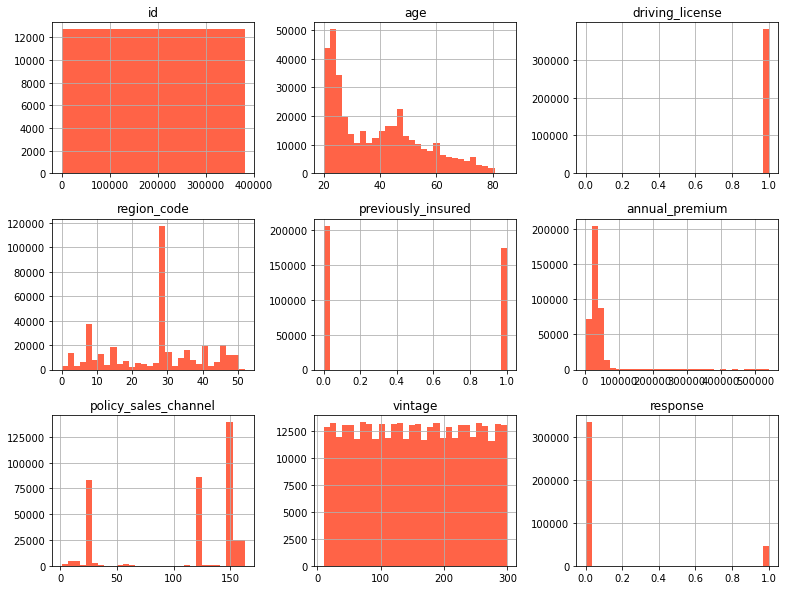

In [12]:
#num_attributes.drop(columns = ['id'], inplace = True)
plt.figure(figsize=(20,10))
num_attributes.hist(bins = 30, figsize=(13,10), color = 'tomato');

### 1.4.2 Categorical Attributes

In [13]:
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


# 2.0 Feature Engeneering

In [14]:
df2 = df1.copy()

In [15]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                 if x == '1-2 Year' else 'below_1_year' ) 

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x:1 if x == 'Yes' else 0 )

In [16]:
df2['vehicle_age'].unique()

array(['over_2_years', 'between_1_2_year', 'below_1_year'], dtype=object)

# 3.0  Data Filtering

In [17]:
df3= df2.copy()

Pela análise das Features e as restrições de negócio, nesse primeiro ciclo não será necessário filtrar nenhuma variável.

# 4.0 EDA

In [18]:
df4 = df3.copy()

## 4.1 Univariate Analysis

C:\Users\PC\anaconda3\envs\pa004\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



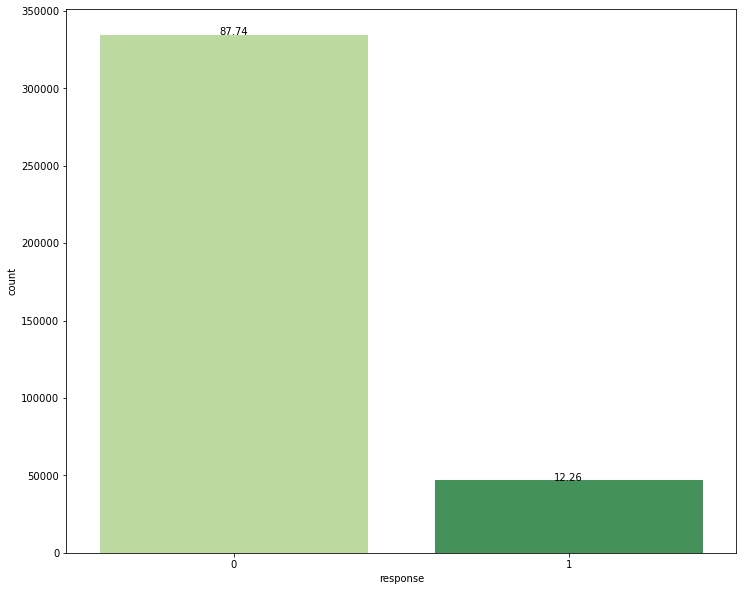

In [19]:
#Response Variable
plt.figure(figsize=(12,10))
ax=sns.countplot(df4['response'], palette = 'YlGn')
total=len(df4['response'])
graphic_percentage(ax,total)

<AxesSubplot:xlabel='response', ylabel='age'>

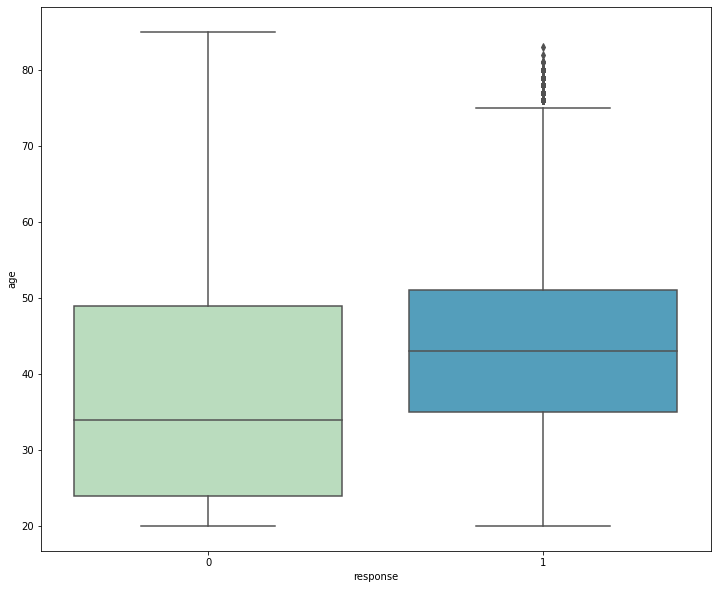

In [20]:
#Age
plt.figure(figsize=(12,10))
sns.boxplot( x='response', y='age', data=df4, palette='GnBu')

Com esse gráfico é possível observar que no grupo de pessoas não interessadas a mediana da idade em torno de 35 anos

Já no grupo dos interessados a mediana da idade está entre 45 e 50 anos

Text(0.5, 1.0, 'interest in insurance by vehicle age')

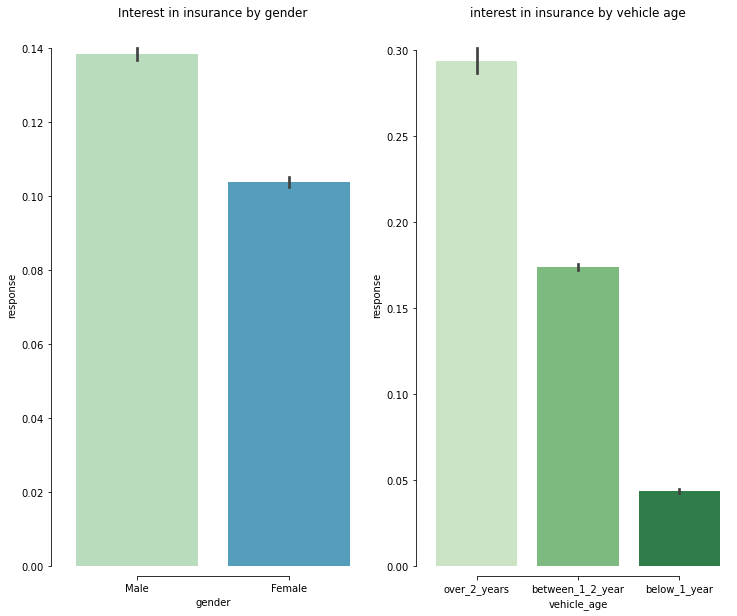

In [21]:
#Gender
plt.figure(figsize=(12,10))
plt.subplot( 1, 2, 1 )
sns.barplot( x='gender', y='response', data=df4, palette= 'GnBu' )
sns.despine(offset = 10, trim = True)
plt.title('Interest in insurance by gender')

plt.subplot( 1, 2, 2 )
sns.barplot( x='vehicle_age', y='response', data=df4, palette='Greens' )
sns.despine(offset = 10, trim = True)
plt.title('interest in insurance by vehicle age')



In [22]:
#Driving_license
df4['driving_license'] = df4['driving_license']

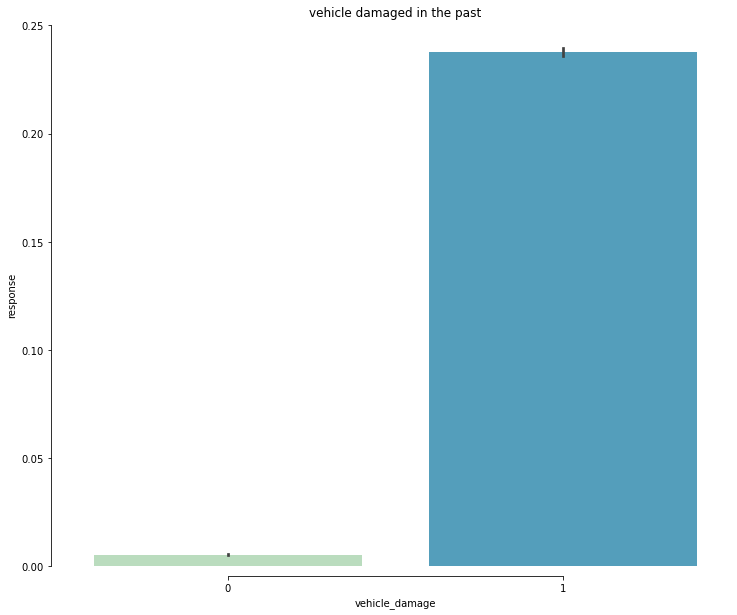

In [23]:
# vehicle_damage x response
plt.figure(figsize=(12,10))
sns.barplot( x='vehicle_damage', y='response', data=df4, palette='GnBu' )
sns.despine(offset = 10, trim = True)
plt.title('vehicle damaged in the past');

<AxesSubplot:xlabel='age', ylabel='Count'>

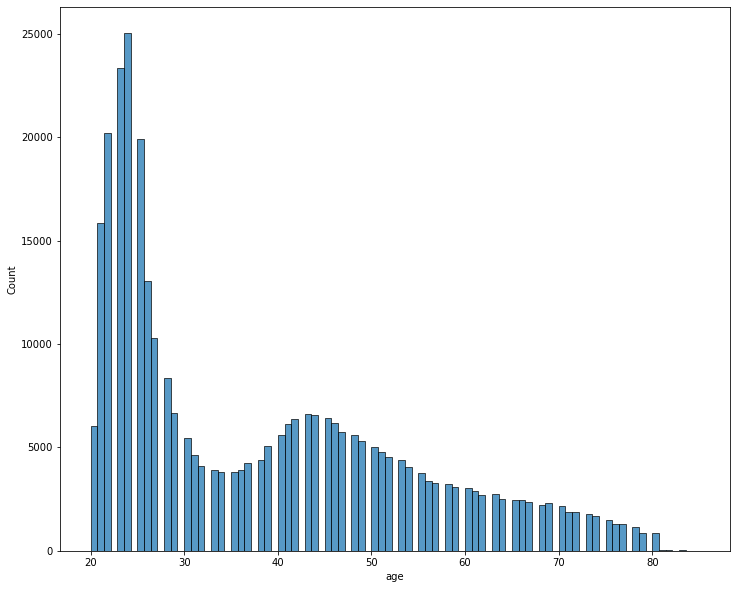

In [24]:
# Response  x Age
aux00 = df4.loc[df4['response']==0, 'age']

plt.figure(figsize=(12,10))
sns.histplot(aux00)



<AxesSubplot:xlabel='age', ylabel='Count'>

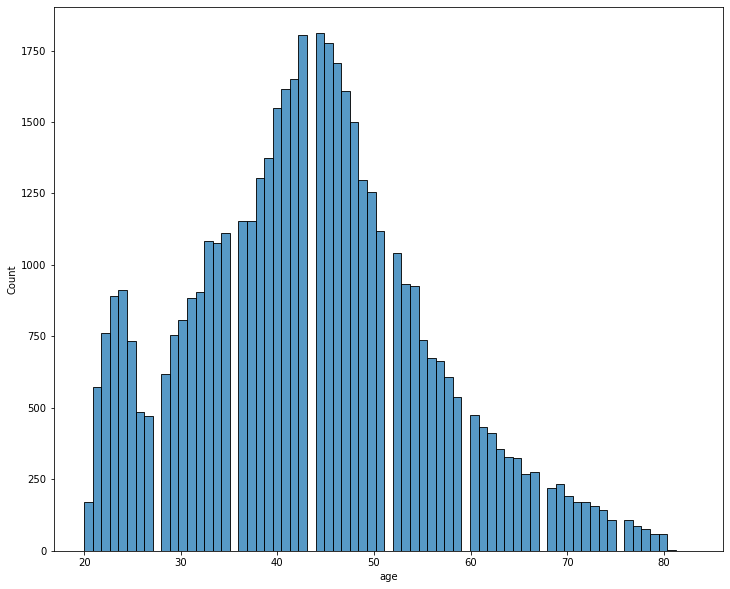

In [25]:
aux01 = df4.loc[df4['response']==1, 'age']

plt.figure(figsize=(12,10))
sns.histplot(aux01)

Os gráficos confirmam a informação de que no gupo de pessoas não interessadas há uma concentração de entre 20 e 30 anos

já no grupo de pessoas interessadas a concentração maior está entre40 e 50 anos

É possivel perceber também que o número de pessoas no grupo de não interessadas é muito maior do que a de possas interessadas.

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

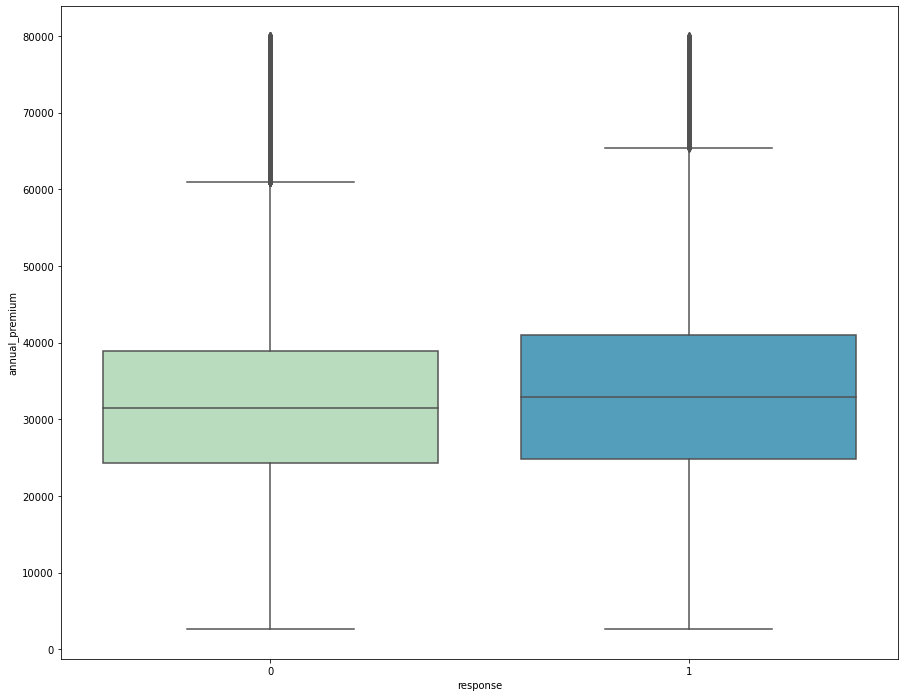

In [26]:
# Anual premium
aux = df4[df4['annual_premium']<80000]
plt.figure(figsize=(15,12))
sns.boxplot(x='response', y='annual_premium',data=aux, palette='GnBu')


<AxesSubplot:xlabel='response', ylabel='annual_premium'>

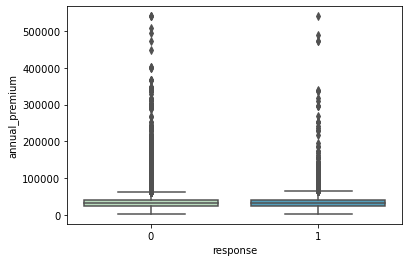

In [27]:
# Anual premium
sns.boxplot(x='response', y='annual_premium',data=df4, palette='GnBu')

É possível perceber que há muitos outliers, mas não podemos descartá-las, pois ela pode ajudar em conjunto com outras variáveis

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

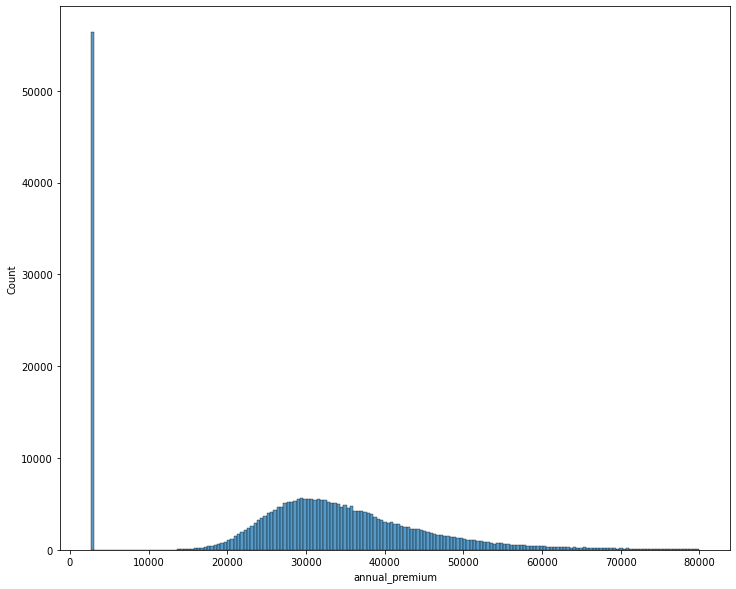

In [28]:
# Anual premium
aux00 =aux.loc[aux['response']==0, 'annual_premium']

plt.figure(figsize=(12,10))
sns.histplot(aux00)


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

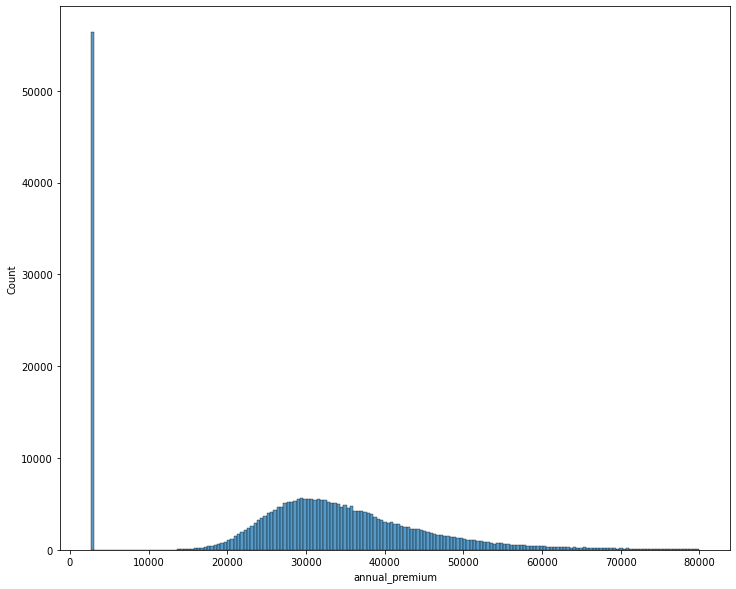

In [29]:
aux = aux.loc[aux['response']==1, 'annual_premium']

plt.figure(figsize=(12,10))
sns.histplot(aux00)

,response,driving_license,driving_license_percent
0,0,333628,0.877283
1,1,46669,0.122717


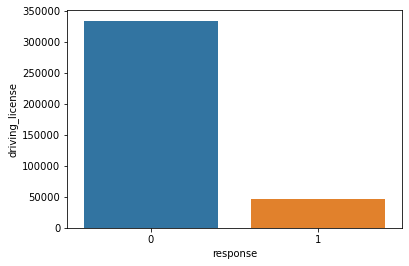

In [30]:
# Driving Licences
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_percent'] = aux['driving_license'] / aux['driving_license'].sum()
sns.barplot(x='response', y= 'driving_license', data=aux)

aux

O grupo de pessoas que dirigem e não querem fazer o seguro é de 87%

<AxesSubplot:xlabel='region_code', ylabel='id'>

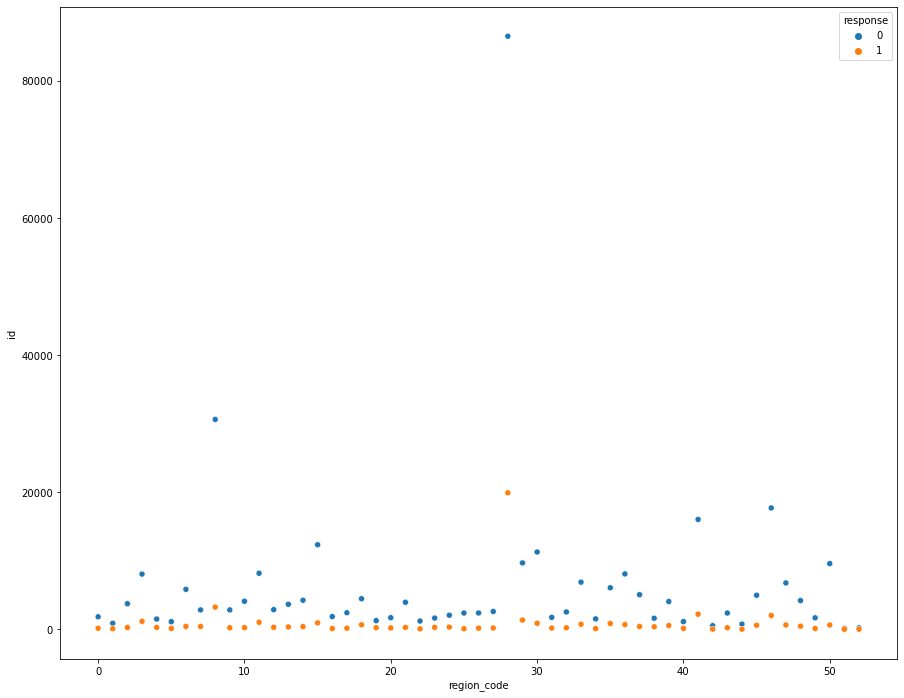

In [31]:
#Region code
#A ideia aqui é verificar se o region code pode ser agrupado de alguma maneira
aux0 = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
plt.figure(figsize=(15,12))
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

É possivel observar nesse gráfico que apenas um grupo tem mais de 8000 pessoas que não está interessada, porém os demais estão mais perto um do outro.

In [32]:
# previously insured

pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


É possivel perceber que das pessoas que tem seguro, menos de 1% teria interesse no seguro pro carro

In [33]:
# vehicle age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


Pessoas que tem carro mais novos não gostariam de tem um novo seguro

Para carros novos e seminovos há uma grande diferença entre quem tem interesse e quem não tem;

Para que tem carros mais antigos, a discrepancia não é tão grande

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
policy_sales_channel,123.0,43.0,27.000000,28.000000,36.000000,155.000000,163.000000,3.000000,121.000000,101.000000,87.000000,80.000000,81.000000,158.00000,90.000000
response,1.0,1.0,0.333333,0.333333,0.326923,0.320097,0.304183,0.304015,0.296875,0.285714,0.285714,0.285714,0.285714,0.27439,0.269231


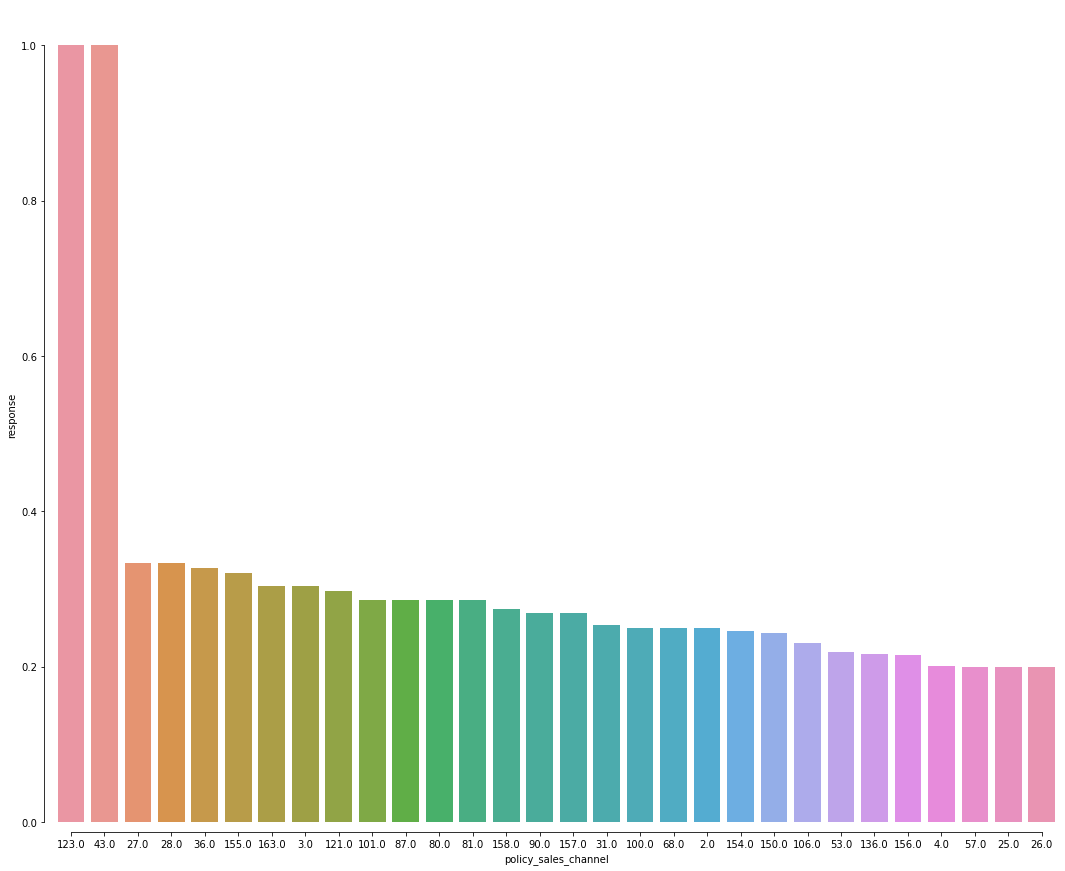

In [34]:
#Policy sales channel
aux = df2[['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().sort_values(by = 'response', ascending = False).reset_index() 
plt.figure(figsize=(18,15))
sns.barplot(x = 'policy_sales_channel', y = 'response', data = aux.head(30), order = aux['policy_sales_channel'].head(30))
sns.despine(offset = 10, trim = True);
aux.head(15).T

In [35]:
aux1 = df2[df2['response'] == 1]
aux2 = df2[df2['response'] == 0]

x = aux1['vintage'].mean()
y = aux2['vintage'].mean()

print('vintage of interested     (mean):', x)
print('vintage of not interested (mean):', y)


vintage of interested     (mean): 154.11224577178334
vintage of not interested (mean): 154.38024336197176


## 4.3 Hypothesis Validation

**H1 - Mulheres tem mais interesse em comprar seguro de veículos que homens.**

**False** De acordo com os dados disponíveis neste dataset, os homens são os mais interessados em contratar um seguro


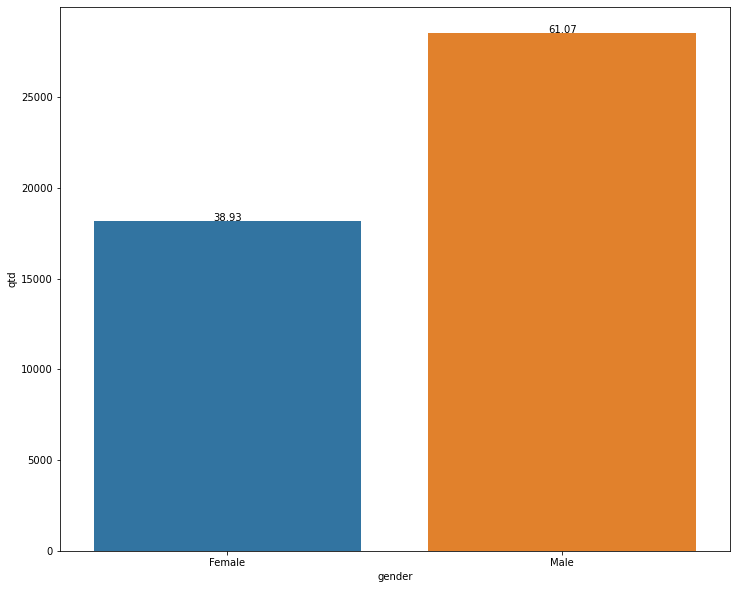

In [36]:

aux=df4[df4['response']==1]
plt.figure(figsize=(12,10))
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)

**H2 - Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.**

**Verdadeira** - Cliente com carros seminovos e novos correspondem a aproximadamente 90% dos interessados em adquirir um seguro de veículo

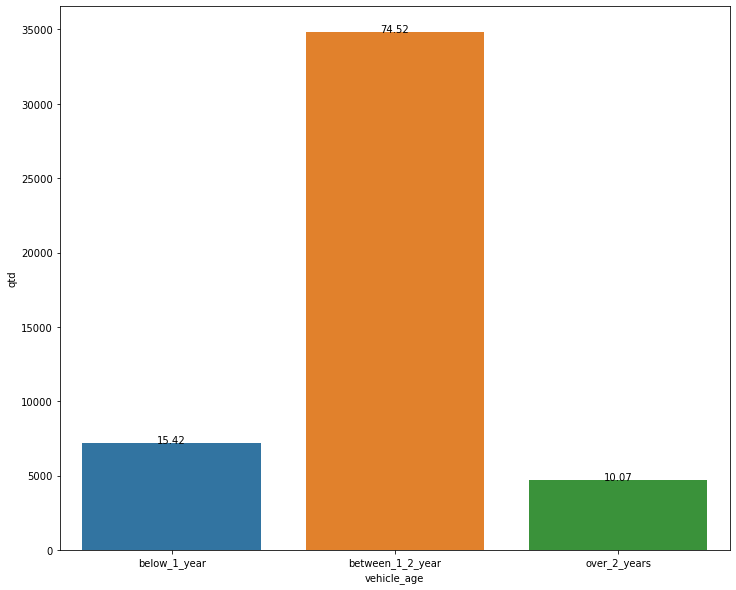

In [37]:
aux=df4[df4['response']==1]
aux=aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
plt.figure(figsize=(12,10))
ax=sns.barplot(data=aux,x='vehicle_age',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

**H3 - Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.**

**Falsa** - Uma pequena parcela de pessoas (0.01%), embora não tenham carteira de motorista estão interessados no seguro de veículos

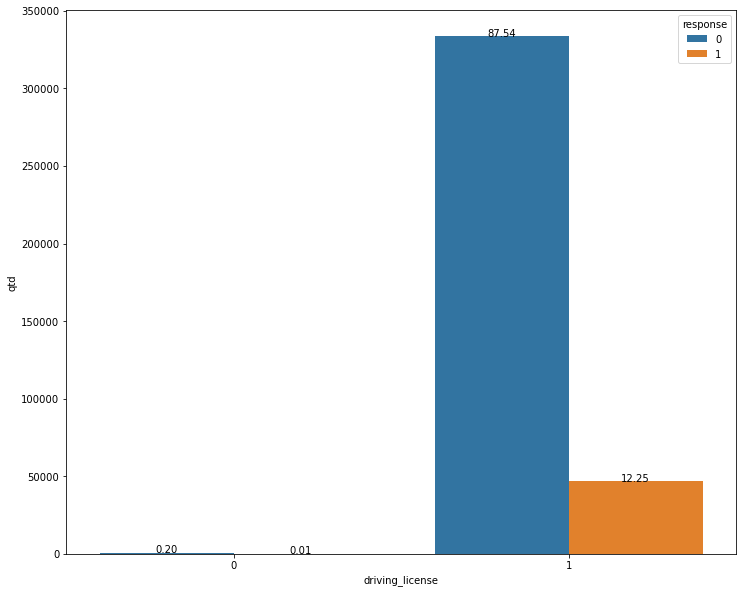

In [38]:
aux=df4[['driving_license','response']].groupby(['driving_license','response']).size().reset_index().rename(columns={0:'qtd'})
plt.figure(figsize=(12,10))
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

**H4 - Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.**

**Verdadeira** - 98% dos clientes interessados no seguro ja sofreram algum tipo de acidentes.

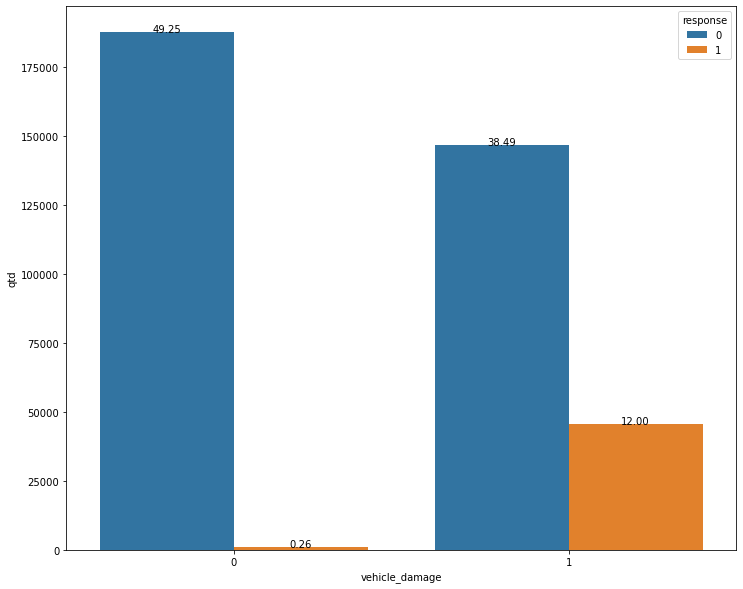

In [39]:
aux=df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'qtd'})
plt.figure(figsize=(12,10))
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

**H5 - Homens tem mais eventos de dano a veículos, do que mulheres.**

**Verdadeira** - Homens representam 58,35% dos eventos de dano à veículos, enquanto as mulheres representam 41,65% dos eventos.

In [40]:
pd.crosstab( df4['gender'], df4['vehicle_damage'] )

vehicle_damage,0,1
gender,,
Female,95355,79665
Male,93341,112748


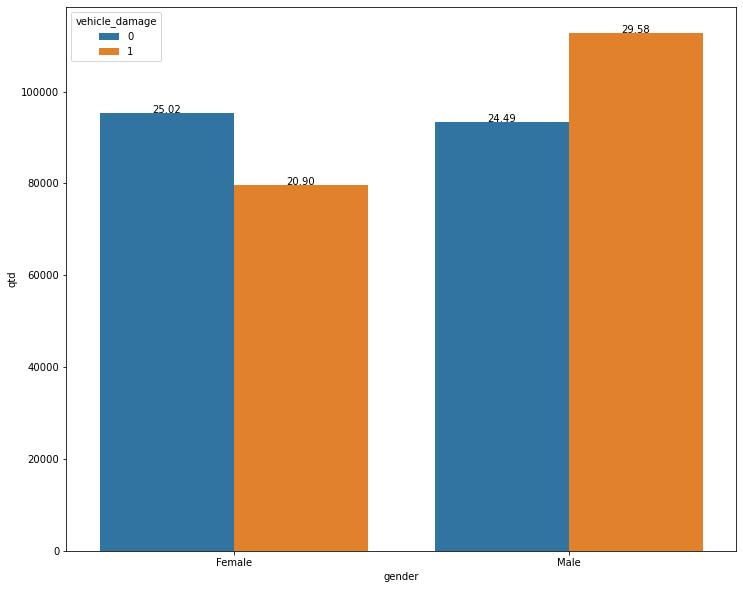

In [41]:
aux=df4[['vehicle_damage','gender']].groupby(['vehicle_damage','gender']).size().reset_index().rename(columns={0:'qtd'})
plt.figure(figsize=(12,10))
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

# 5.0 Data Preparation

In [42]:
df5= df4.copy()

### Split dataframe into training and validation dataset

In [43]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [44]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
#pickle.dump( ss, open( '../pa004_health_insurance/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescaling

In [45]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump( mms_age, open( '../pa004_health_insurance/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump( mms_vintage, open( '../pa004_health_insurance/features/vintage_scaler.pkl', 'wb' ) )



## 5.3 Encoder

In [46]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump( target_encode_gender, open( '../pa004_health_insurance/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open( '../pa004_health_insurance/features/target_encode_region_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
target_encode_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( target_encode_policy_sales_channel )
#pickle.dump(target_encode_policy_sales_channel, open( '../pa004_health_insurance/features/target_encode_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.2 Validation Preparation

In [47]:
 # gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( target_encode_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 Feature Selection

Esta etapa server para determinar qual é a melhor combinação de variáveis a ser utilizada.



## 6.1 Feature importance

### 6.1.1 Extra Trees Classifier

O Extremely Randomized Trees Classifier (Extra Trees Classifier) é um tipo de técnica de aprendizagem de conjunto que agrega os resultados de várias árvores de decisão descorrelacionadas coletadas em uma “floresta” para produzir seu resultado de classificação. Em conceito, é muito semelhante a um Classificador Random Forest e só difere na forma de construção das árvores de decisão na floresta.

Cada árvore de decisão na floresta de árvores extras é construída a partir da amostra de treinamento original. Então, em cada nó de teste, cada árvore é fornecida com uma amostra aleatória de k recursos do conjunto de recursos a partir do qual cada árvore de decisão deve selecionar o melhor recurso para dividir os dados com base em alguns critérios matemáticos (normalmente o índice de Gini). Essa amostra aleatória de recursos leva à criação de várias árvores de decisão não correlacionadas.

Para realizar a seleção de características usando a estrutura de floresta acima, durante a construção da floresta, para cada característica, a redução total normalizada nos critérios matemáticos usados ​​na decisão da característica de divisão (Índice de Gini se o Índice de Gini for usado na construção de floresta) é computado. Esse valor é chamado de Importância Gini do recurso. Para realizar a seleção de recursos, cada recurso é ordenado em ordem decrescente de acordo com a Importância Gini de cada recurso e o usuário seleciona os k principais recursos de acordo com sua escolha.

In [ ]:
# model definition
#et_model = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )
#
# data preparation
#x_train_n = df5.drop( ['id', 'response'], axis=1 )
#y_train_n = y_train.values
#et_model.fit( x_train_n, y_train_n )

In [ ]:
#importances = et_model.feature_importances_
#indices = np.argsort( importances )[::-1]
#
#print( 'feature ranking')
#df = pd.DataFrame()
#
#for i, j in zip( x_train_n, et_model.feature_importances_ ):
#    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
#    df = pd.concat( [df, aux], axis=0 )
#    
#print( df.sort_values( 'importance', ascending=False ) )
#
## Plot the impurity-based feature importances of the forest
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(x_train_n.shape[1]), importances[indices], color="c", align="center")
#plt.xticks(range(x_train_n.shape[1]), indices)
#plt.xlim([-1, x_train_n.shape[1]])
#plt.show()

# 7.0 Machine Learning Modelling

In [48]:
cols_selected = [ 'annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [50]:
x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 Logistic regression

In [51]:
#model definition
#lr_model = lm.LogisticRegression( random_state=42 ) 
# #model training
#lr_model.fit( x_train, y_train )
# #model prediction
#yhat_lr = lr_model.predict_proba( x_val )

In [52]:
# save the lr_model trained model
#with open( 'model/lr_model.pkl', 'wb') as file:
#    pickle.dump( lr_model, file )

In [53]:
# Load the Model back from file
with open('model/lr_model.pkl', 'rb') as file:  
    lr_model = pickle.load( file )

In [54]:
# model prediction - probability
#yhat_lr = lr_model.predict_proba( x_val )

In [55]:
# model size
#lr_model_size_mb = round( os.path.getsize('model/lr_model.pkl') / (1024**2), 2)

## 7.2 KNN

In [56]:
 # model definition
#knn_model = nh.KNeighborsClassifier( n_neighbors=7 )
# #model training
#knn_model.fit( x_train, y_train )
## model predicion - Poder de Generalização do modelo
#yhat_knn = knn_model.predict_proba( x_val )


In [57]:
# save the knn_model trained model
#with open( 'model/knn_model.pkl', 'wb') as file:
#    pickle.dump( knn_model, file )

In [58]:
# Load the Model back from file
with open('model/knn_model.pkl', 'rb') as file:  
    knn = pickle.load( file )

In [59]:
# model prediction - probability
#yhat_knn = knn_model.predict_proba( x_val )

In [60]:
# model size
#knn_size_mb = round( os.path.getsize('model/knn_model.pkl') / (1024**2), 2)
#knn_size_mb

## 7.3 Random Forest

In [61]:
# model definition
#rf = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
#Model fit
#rf.fit(x_train, y_train)
 #Model predict
#yhat_rf = rf.predict_proba(x_val)

In [62]:
# save the rf_model trained model
#with open( 'model/rf.pkl', 'wb') as file:
#    pickle.dump( rf, file )

In [63]:
# Load the Model back from file
with open('model/rf.pkl', 'rb') as file:  
    knn = pickle.load( file )

## 7.4 XGBoost

In [64]:
 # model definition
#xgb = XGBClassifier( use_label_encoder = False, n_jobs = -1, seed = 10 )
# # model training
#xgb.fit(x_train, y_train);

## model prediction - probability
#yhat_xgb = xgb.predict_proba( x_val )

In [65]:
 #save the xgb_model trained model
#with open( 'model/xgb.pkl', 'wb') as file:
#    pickle.dump( xgb, file )

In [66]:
# Load the Model back from file
with open('model/xgb.pkl', 'rb') as file:  
    knn = pickle.load( file )

## 7.5 LightGBM

In [67]:
# model definition
#lgbm = LGBMClassifier( n_jobs = -1, random_state = 10 )
 #model training
#lgbm.fit(x_train, y_train)
# model prediction - probability
#yhat_lgbm = lgbm.predict_proba( x_val )

In [68]:
# save the xgb_model trained model
#with open( 'model/lgbm.pkl', 'wb') as file:
   # pickle.dump( lgbm, file )

In [69]:
# Load the Model back from file
with open('model/lgbm.pkl', 'rb') as file:  
    knn = pickle.load( file )

# 8.0 Model Performance

NameError: name 'yhat_lr' is not defined

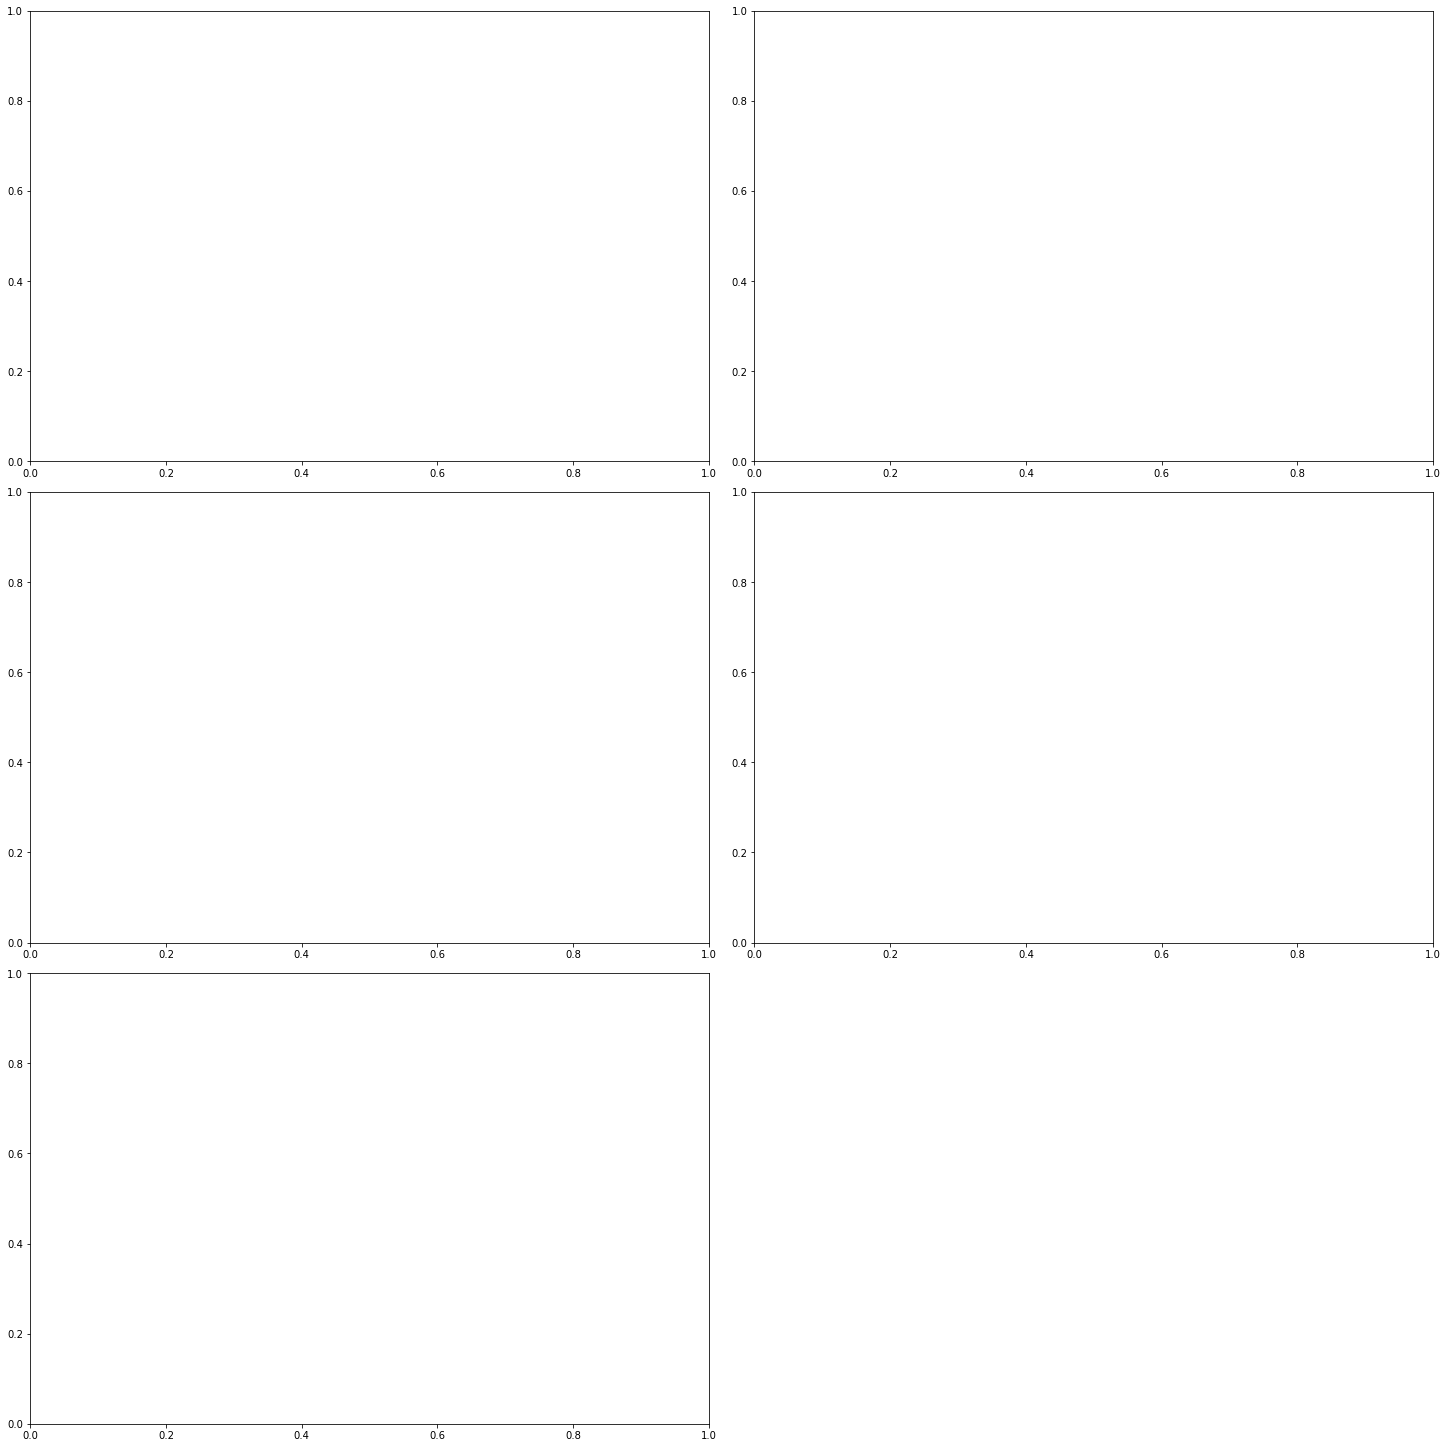

In [70]:
# create a figure object
fig = plt.figure( figsize = (20, 20) , constrained_layout = True )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 2, nrows = 3, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )
ax4 = fig.add_subplot( specs[ 0, 1 ] )
ax5 = fig.add_subplot( specs[ 1, 1 ] )


# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                   yhat_lr, 
                                    title = 'LOGISTIC REGRESSION', ax = ax1    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_knn,
                                    title = 'KNN',                 ax = ax2    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_rf,
                                    title = 'RANDOM FOREST',       ax = ax3    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_lgbm, 
                                    title = 'LIGHTGBM',            ax = ax4    )


# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation,                  yhat_xgb,
                                    title = 'XGBOOST',             ax = ax5    )



In [71]:
# list predictions made
yhat_predictions = { 'Logistic Regression': [yhat_lr] , 
                     'KNN': [yhat_knn], 
                     'Random Forest': [yhat_rf],
                     'XGBoost': [yhat_xgb],
                     'LightGBM': [yhat_lgbm],
                     }

# create dataframe to compare models
performance_comparison = pd.DataFrame()

for model_name, model in yhat_predictions.items():
    # create model key
    row = {'Model': model_name}
    
    # create model 
   # row['Size in MB'] = model[1]
        
    # order validation according to propensity score
    df_propensity_ordered = propensity_score_ordering( x_validation, y_validation, model[0])

    # compute precision at k
    row['recall_at_20000'] = recall_at_k(  df_propensity_ordered, k = 20000 )
    row['recall_at_40000'] = recall_at_k(  df_propensity_ordered, k = 40000 )
        
    # compute precision at k
    row['precision_at_20000'] = precision_at_k( df_propensity_ordered, k = 20000 )
    row['precision_at_40000'] = precision_at_k( df_propensity_ordered, k = 40000 )
            
    # append to comparison dataframe    
    performance_comparison = performance_comparison.append(row, ignore_index = True)

performance_comparison.sort_values( ['recall_at_20000', 'recall_at_40000'], 
                                    ascending = False )    

NameError: name 'yhat_lr' is not defined

## 8.1 Model Selection

Due to the above explanation, the chosen model is LightGBM.

# 9.0 HYPERPARAMETER FINE TUNING

In [72]:
# params_search = { 
#     'n_estimators': [30, 100, 300],
#     'learning_rate': [0.03, 0.1, 0.3],
#     'num_leaves': [10, 30, 100],
#     }

# # create best params dataframe
# df_params_performance = pd.DataFrame()

# # number of iterations
# total_iterations = np.prod( [len(value) for value in params_search.values()] )

# # initialize iterations
# iteration = 1

# # perform RANDOM SEARCH to find best params
# for n_est in params_search['n_estimators']:
#     for l_rate in params_search['learning_rate']:
#         for n_lvs in params_search['num_leaves']:
#             # display iteration number
#             print( f'At {iteration} / {total_iterations} iteration.')
            
#             # define choosen params
#             chosen_params = { 'n_estimators':  n_est,
#                               'learning_rate': l_rate,
#                               'num_leaves':    n_lvs
#                             }                            
                
#             # define model with random params
#             lgbm = LGBMClassifier( n_estimators  = n_est,
#                                    learning_rate = l_rate,
#                                    num_leaves    = n_lvs,
#                                    n_jobs        = -1,
#                                    random_state  = 10
#                                  )  

#             # train model
#             lgbm.fit( X_train_model, y_train_model )

#             # model prediction
#             yhat_lgbm = lgbm.predict_proba( X_validation_model )

#             # order validation according to propensity score
#             df_propensity_ordered = propensity_score_ordering( X_validation, y_validation, yhat_lgbm )

#             # compute precision at k
#             precision_at_20000 = precision_at_k( df_propensity_ordered, k = 20000 )
#             precision_at_40000 = precision_at_k( df_propensity_ordered, k = 40000 )

#             # compute precision at k
#             recall_at_20000 = recall_at_k( df_propensity_ordered, k = 20000 )
#             recall_at_40000 = recall_at_k( df_propensity_ordered, k = 40000 )

#             # create row for dataframe appending
#             row = chosen_params
#             row['recall_at_20000']    = recall_at_20000
#             row['recall_at_40000']    = recall_at_40000
#             row['precision_at_40000'] = precision_at_40000,
#             row['precision_at_20000'] = precision_at_20000,

#             # append row to dataframe
#             df_params_performance = df_params_performance.append(row, ignore_index = True)

#             # increase iteration number
#             iteration += 1

            
# df_params_performance.sort_values( ['recall_at_20000', 'recall_at_40000', 
#                                     'precision_at_20000', 'precision_at_40000'], ascending = False )


In [73]:
# best params according to random search
best_params = { 'n_estimators': 30,
                'learning_rate': 0.1,
                'num_leaves': 10,
              }

## 9.1 PERFORMANCE EVALUATION AND INTERPRETATION

### 9.1.1 Learning Performance

In [74]:
# define final model with optimal hyperparameters
lgbm_tuned = LGBMClassifier( n_estimators = 30, learning_rate = 0.1,
                             num_leaves = 10,  n_jobs = -1, random_state = 10 )                     

# model training
lgbm_tuned.fit( x_train, y_train )

LGBMClassifier(n_estimators=30, num_leaves=10, random_state=10)

In [75]:
# model prediction - probability
yhat_lgbm_tuned = lgbm_tuned.predict_proba( x_val)

Recall    at 20.000: 0.7078220040550635
Recall    at 40.000: 0.9943442535481806
Precision at 20.000: 0.33163341832908355
Precision at 40.000: 0.23294417639559012


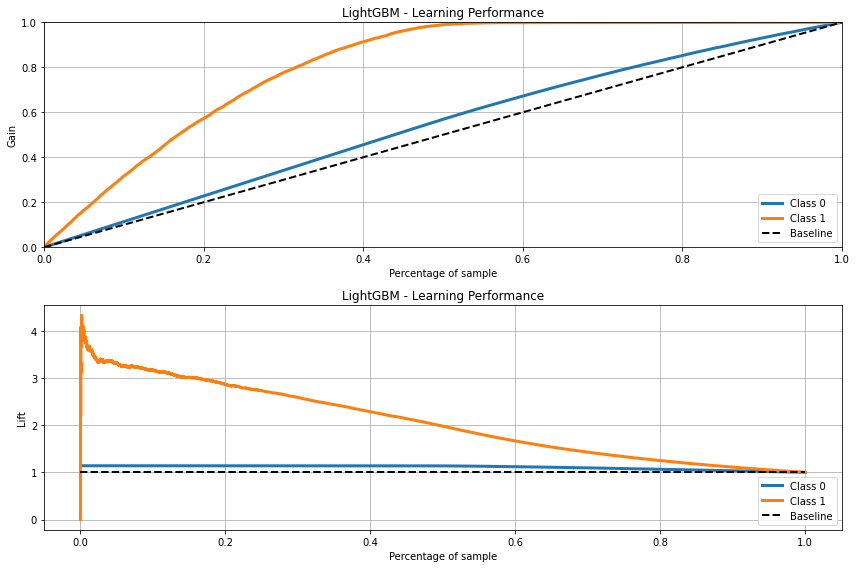

In [76]:
# order validation according to propensity score
df_propensity_ordered = propensity_score_ordering( x_validation, y_validation, yhat_lgbm_tuned)

# compute recall at k
recall_at_20000 = recall_at_k( df_propensity_ordered, k = 20000 )
print( f'Recall    at 20.000: {recall_at_20000}' )    
recall_at_40000 = recall_at_k( df_propensity_ordered, k = 40000 )
print( f'Recall    at 40.000: {recall_at_40000}' )    

# compute precision at k
precision_at_20000 = precision_at_k( df_propensity_ordered, k = 20000 )
print( f'Precision at 20.000: {precision_at_20000}' )
precision_at_40000 = precision_at_k( df_propensity_ordered, k = 40000 )
print( f'Precision at 40.000: {precision_at_40000}' )

# prepare figure
fig = plt.figure( figsize = (12,8), tight_layout = True )

# create subplots
ax1 = fig.add_subplot( 211 )
ax2 = fig.add_subplot( 212 )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm_tuned, 
                                    title = 'LightGBM - Learning Performance', ax = ax1 )

# plot lift curve
skplt.metrics.plot_lift_curve( y_validation, yhat_lgbm_tuned, 
                               title = 'LightGBM - Learning Performance', ax = ax2 );

In [77]:
x_validation.shape

(76222, 13)

In [78]:
x_train.shape

(304887, 7)

In [ ]:
 # Save the lgbm trained model
#with open( 'model/model_health_insurance.pkl', 'wb' ) as file:
        #pickle.dump( lgbm_tuned, file )

In [80]:
# Load the Model back from file
with open( 'model/model_health_insurance.pkl', 'rb') as file:  
    model_health_insurance = pickle.load( file )

### Generalization Performance

In [81]:
# model prediction
yhat_model_health_insurance = model_health_insurance.predict_proba( x_val )

# 9.0 Deploy to production

In [82]:
#saved trained model
#pickle.dump(lgbm, open( 'C:/Users/PC/SejaUmDataScientist/DS_Classificacao/pa004_health_insurance/model/model_health_insurance.pkl', 'wb'))

## 9.1 Health Insurance Class

In [124]:
import pickle
import numpy  as np
import numpy  as np
import pandas as pd

class HealthInsurance(object):
    
    def __init__(self):
        self.home_path ='C:/Users/PC/SejaUmDataScientist/DS_Classificacao/pa004_health_insurance/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'features/age_scaler.pkl', 'rb' ) ) 
        self.target_encode_vintage_scaler =     pickle.load( open( self.home_path + 'features/target_encode_vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_scaler =      pickle.load( open( self.home_path + 'features/target_encode_region_scaler.pkl', 'rb' ) )
        self.target_encode_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'features/target_encode_policy_sales_channel_scaler.pkl', 'rb' ) )
    
    
    def data_cleaning(self, df1):
        #rename columns 
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
                'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
                'Policy_Sales_Channel', 'Vintage']
        
        #Rename
        df1.columns = cols_new
        
        return df1
    
    def feature_engeneering(self, df2):
        # vehicle age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 
        
        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x:1 if x == 'Yes' else 0 )
        return df2

    def data_preparation(df5):               
              
        # annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )
              
        ## 5.2 Rescaling       
            
        # Age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
                
        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
        
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )
        
        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
        
        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.target_encode_policy_sales_channel_scaler )
        
        cols_selected = ['annual_premium', 'vintage', 'reg0ion_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel' ]
        
        return df5[cols_selected]
    
    
      
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2 API Handler

In [126]:
import requests

In [127]:
#loading Dataset
df_test= x_validation
df_test['response'] = y_validation

In [128]:
df_test = df_test.sample(10)

In [129]:
data= json.dumps(df_test.to_dict(orient='records'))

In [134]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response
14930,14931,0.103984,0.153846,1,0.187822,0,1,0.584036,0.194429,0.823529,0,1,0,0
161514,161515,0.103984,0.400000,1,0.097136,1,1,-0.006094,0.209018,0.941176,0,1,0,0
284035,284036,0.138185,0.076923,1,0.066667,1,0,-0.630590,0.353846,0.754325,1,0,0,0
97277,97278,0.138185,0.723077,1,0.069691,0,1,-0.060893,0.353846,0.591696,0,1,0,0
104490,104491,0.138185,0.015385,1,0.097589,1,0,0.251007,0.353846,0.332180,1,0,0,0
89584,89585,0.138185,0.384615,1,0.123487,1,0,-1.621726,0.209018,0.155709,0,1,0,0
282904,282905,0.138185,0.015385,1,0.187822,0,1,0.348472,0.015468,0.034602,0,1,0,0
203898,203899,0.138185,0.092308,1,0.060997,1,0,-0.342375,0.353846,0.539792,1,0,0,0
253234,253235,0.138185,0.153846,1,0.187822,0,1,0.668962,0.015468,0.169550,1,0,0,0
347528,347529,0.103984,0.707692,1,0.187822,0,1,0.090384,0.209018,0.536332,0,1,0,0


In [131]:
#API call
#url='http://0.0.0.0:5000/healthinsurance/predict'
url= 'https://health-insurance-model.herokuapp.com/predict'
header= {'Content-type': 'application/json'}
r= requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))


Status Code 500


In [ ]:
d1=pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()